# Chapter 2: Decision Trees

This notebook explores decision trees, one of the most intuitive and widely used machine learning algorithms. We'll cover the mathematical foundations, implementation details, and practical applications of decision trees for both classification and regression tasks.

In [3]:
!pip install -q pydotplus

  DEPRECATION: pydotplus is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_iris, load_wine, fetch_california_housing
import graphviz
from IPython.display import Image
import pydotplus
import os
import io

# Configure visualizations
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\aashu\AppData\Local\Temp\ipykernel_21560\3502242390.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. Introduction to Decision Trees

Decision trees are versatile machine learning algorithms that can be used for both classification and regression tasks. They work by recursively splitting the data based on feature values, creating a tree-like model of decisions.

### Key Concepts in Decision Trees:

1. **Root Node**: The topmost node in the tree, representing the entire population or sample.
2. **Decision Node**: A node that branches into further sub-nodes.
3. **Leaf/Terminal Node**: Final outcome nodes that don't split further.
4. **Splitting**: The process of dividing a node into two or more sub-nodes.
5. **Pruning**: Removing sub-nodes of a decision node to reduce complexity and prevent overfitting.
6. **Tree Depth**: The length of the longest path from root to a leaf.
7. **Impurity Measures**: Metrics (like Gini, Entropy, Variance) used to determine the best splits.

### Advantages of Decision Trees:

- Simple to understand and interpret
- Require little data preprocessing (no normalization needed)
- Can handle both numerical and categorical data
- Can model non-linear relationships
- Automatically perform feature selection

### Disadvantages of Decision Trees:

- Prone to overfitting, especially with deep trees
- Can be unstable (small changes in data can result in very different trees)
- May create biased trees if some classes dominate
- Not optimal for capturing linear relationships

## 2. Mathematical Formulation

Decision trees use various impurity measures to determine the optimal split at each node:

### For Classification (Categorical Target):

1. **Gini Impurity**: Measures the probability of incorrect classification.
   - $Gini = 1 - \sum_{i=1}^{C} p_i^2$
   - where $p_i$ is the probability of class $i$

2. **Entropy**: Measures the level of disorder or uncertainty.
   - $Entropy = -\sum_{i=1}^{C} p_i \log_2(p_i)$

3. **Information Gain**: The reduction in entropy after a split.
   - $IG(T, a) = Entropy(T) - \sum_{v \in values(a)} \frac{|T_v|}{|T|} Entropy(T_v)$
   - where $T$ is the current set, $a$ is the attribute, and $T_v$ is the subset of $T$ where attribute $a$ has value $v$.

### For Regression (Continuous Target):

1. **Mean Squared Error (MSE)**: Measures the average squared difference between actual and predicted values.
   - $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2$
   - where $\hat{y}$ is the mean of the target values in the node

2. **Mean Absolute Error (MAE)**: Measures the average absolute difference between actual and predicted values.
   - $MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}|$

The decision tree algorithm selects the attribute and split point that maximizes the reduction in impurity (or minimizes the error for regression) at each step.

## 3. Decision Trees for Classification

In [5]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Print basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")

Dataset shape: (150, 4)
Number of classes: 3
Class distribution: [50 50 50]
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']


In [6]:
# Create a DataFrame for easier data manipulation
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = [target_names[i] for i in y]

# Display the first few rows
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


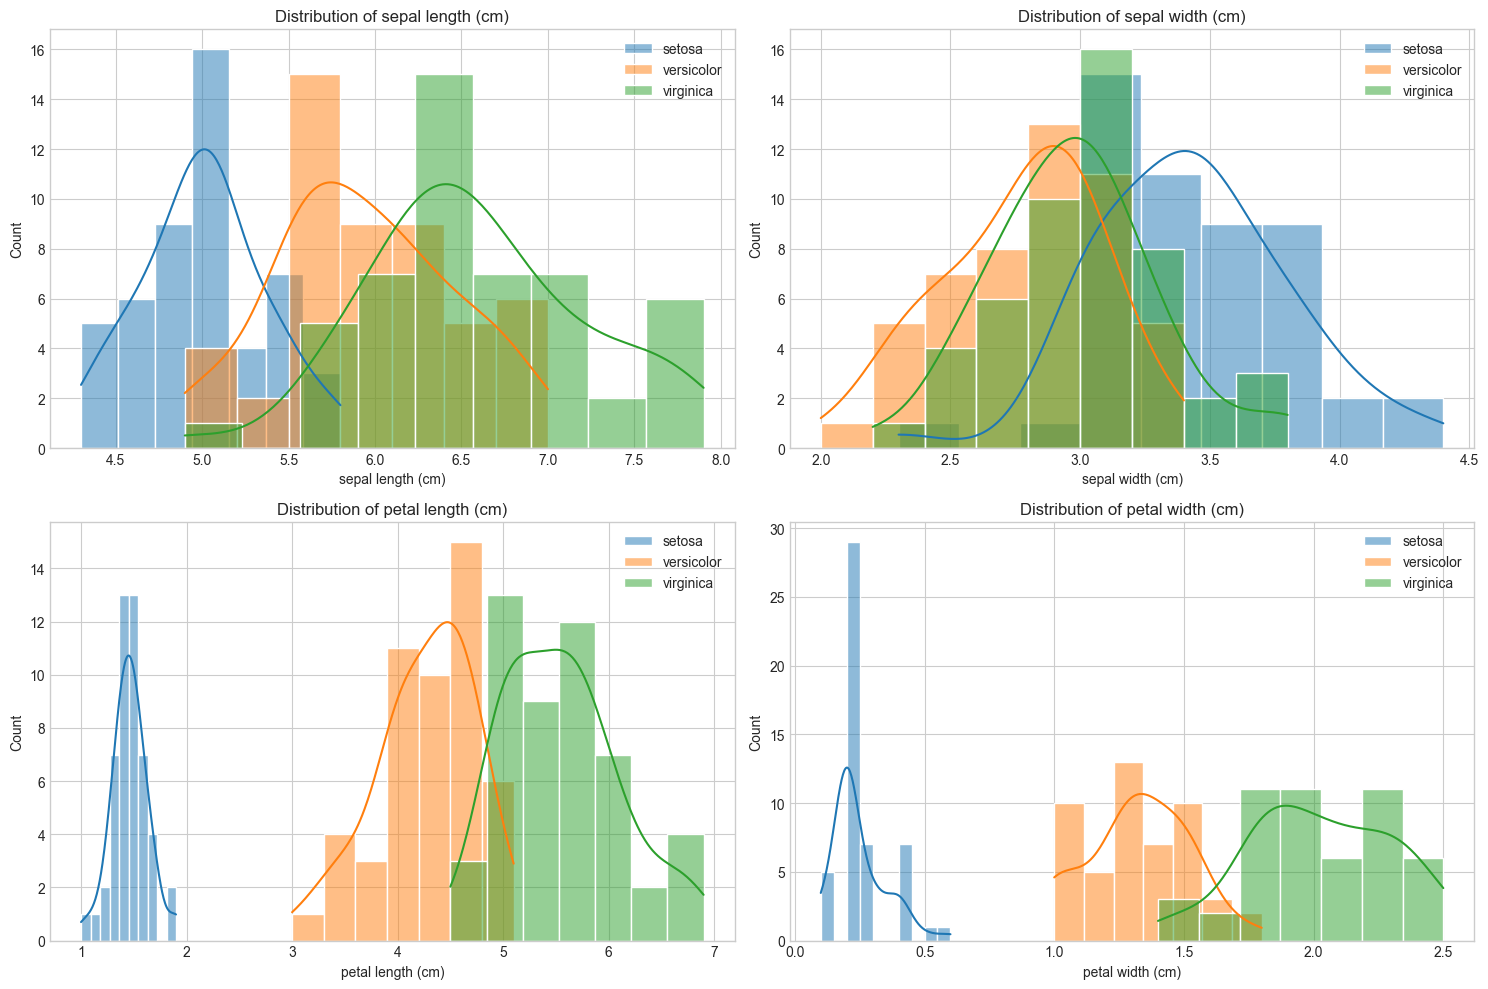

In [7]:
# Explore the data distribution
plt.figure(figsize=(15, 10))

for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for species in target_names:
        subset = iris_df[iris_df['species'] == species]
        sns.histplot(subset[feature], kde=True, label=species)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

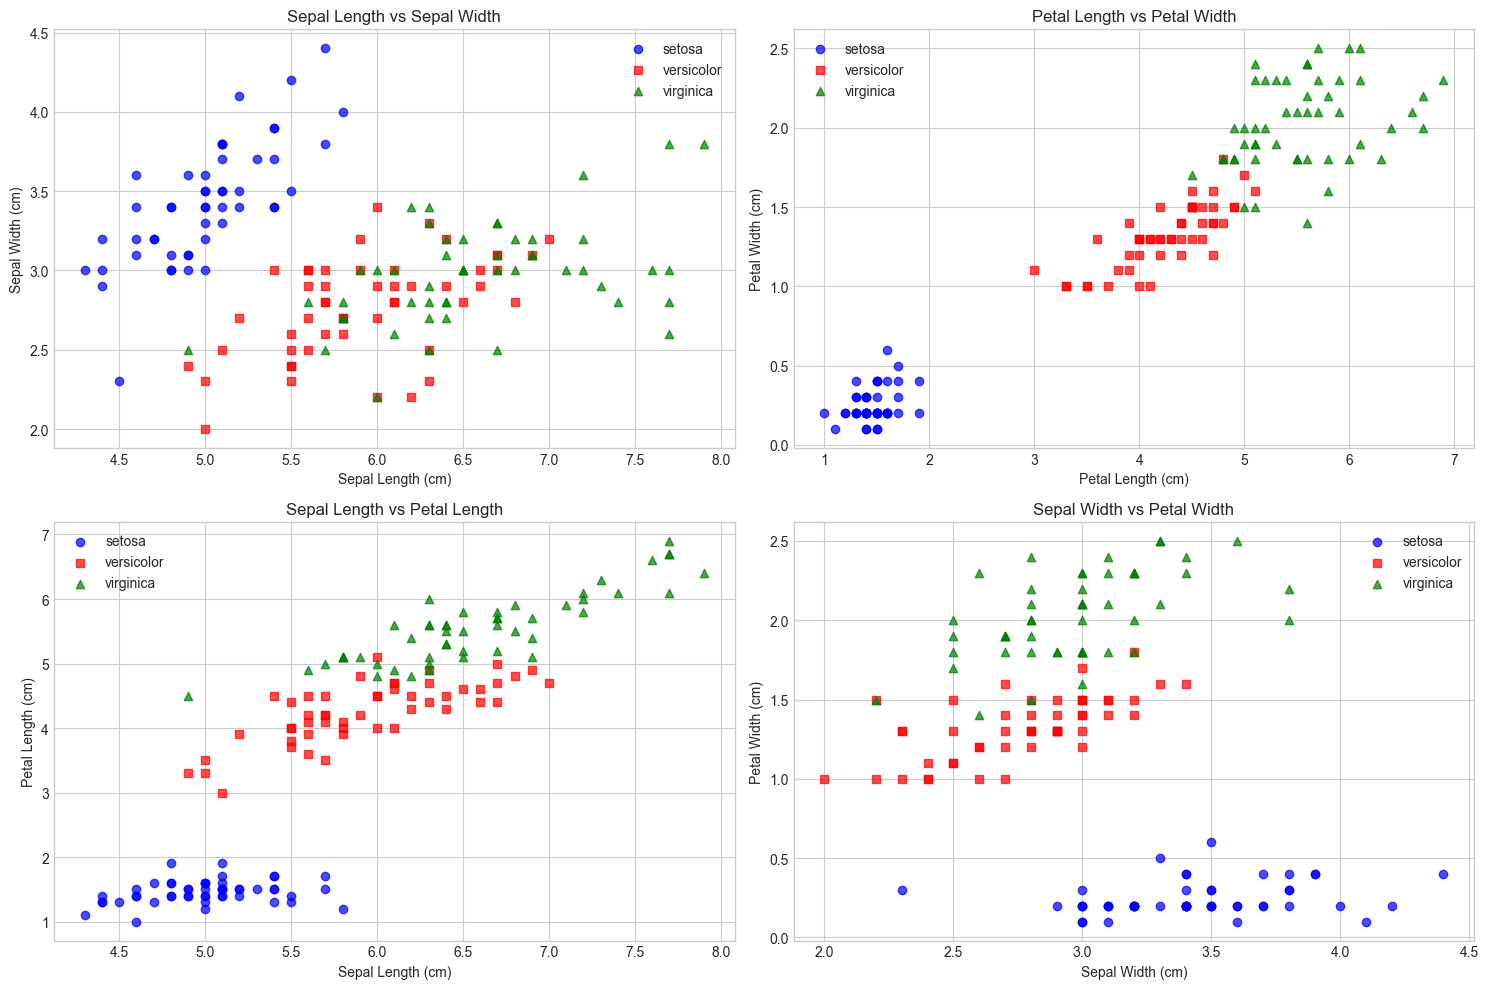

In [8]:
# Create scatter plots to visualize relationships between features
plt.figure(figsize=(15, 10))

# Plot sepal length vs sepal width
plt.subplot(2, 2, 1)
for species, marker, color in zip(target_names, ['o', 's', '^'], ['blue', 'red', 'green']):
    subset = iris_df[iris_df['species'] == species]
    plt.scatter(
        subset['sepal length (cm)'], 
        subset['sepal width (cm)'],
        marker=marker,
        color=color,
        label=species,
        alpha=0.7
    )
plt.title('Sepal Length vs Sepal Width')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend()
plt.grid(True)

# Plot petal length vs petal width
plt.subplot(2, 2, 2)
for species, marker, color in zip(target_names, ['o', 's', '^'], ['blue', 'red', 'green']):
    subset = iris_df[iris_df['species'] == species]
    plt.scatter(
        subset['petal length (cm)'], 
        subset['petal width (cm)'],
        marker=marker,
        color=color,
        label=species,
        alpha=0.7
    )
plt.title('Petal Length vs Petal Width')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.grid(True)

# Plot sepal length vs petal length
plt.subplot(2, 2, 3)
for species, marker, color in zip(target_names, ['o', 's', '^'], ['blue', 'red', 'green']):
    subset = iris_df[iris_df['species'] == species]
    plt.scatter(
        subset['sepal length (cm)'], 
        subset['petal length (cm)'],
        marker=marker,
        color=color,
        label=species,
        alpha=0.7
    )
plt.title('Sepal Length vs Petal Length')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Petal Length (cm)')
plt.legend()
plt.grid(True)

# Plot sepal width vs petal width
plt.subplot(2, 2, 4)
for species, marker, color in zip(target_names, ['o', 's', '^'], ['blue', 'red', 'green']):
    subset = iris_df[iris_df['species'] == species]
    plt.scatter(
        subset['sepal width (cm)'], 
        subset['petal width (cm)'],
        marker=marker,
        color=color,
        label=species,
        alpha=0.7
    )
plt.title('Sepal Width vs Petal Width')
plt.xlabel('Sepal Width (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set shape: (105, 4)
Testing set shape: (45, 4)
Training set class distribution: [35 35 35]
Testing set class distribution: [15 15 15]


Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.80      0.89        15
   virginica       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



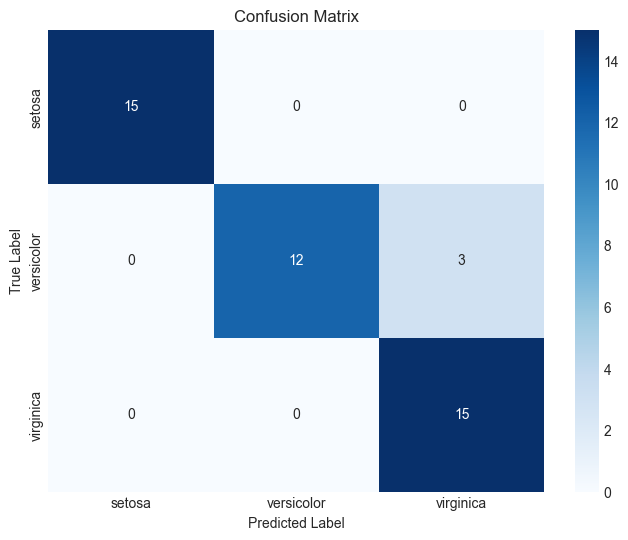

In [10]:
# Train a decision tree classifier with default parameters
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

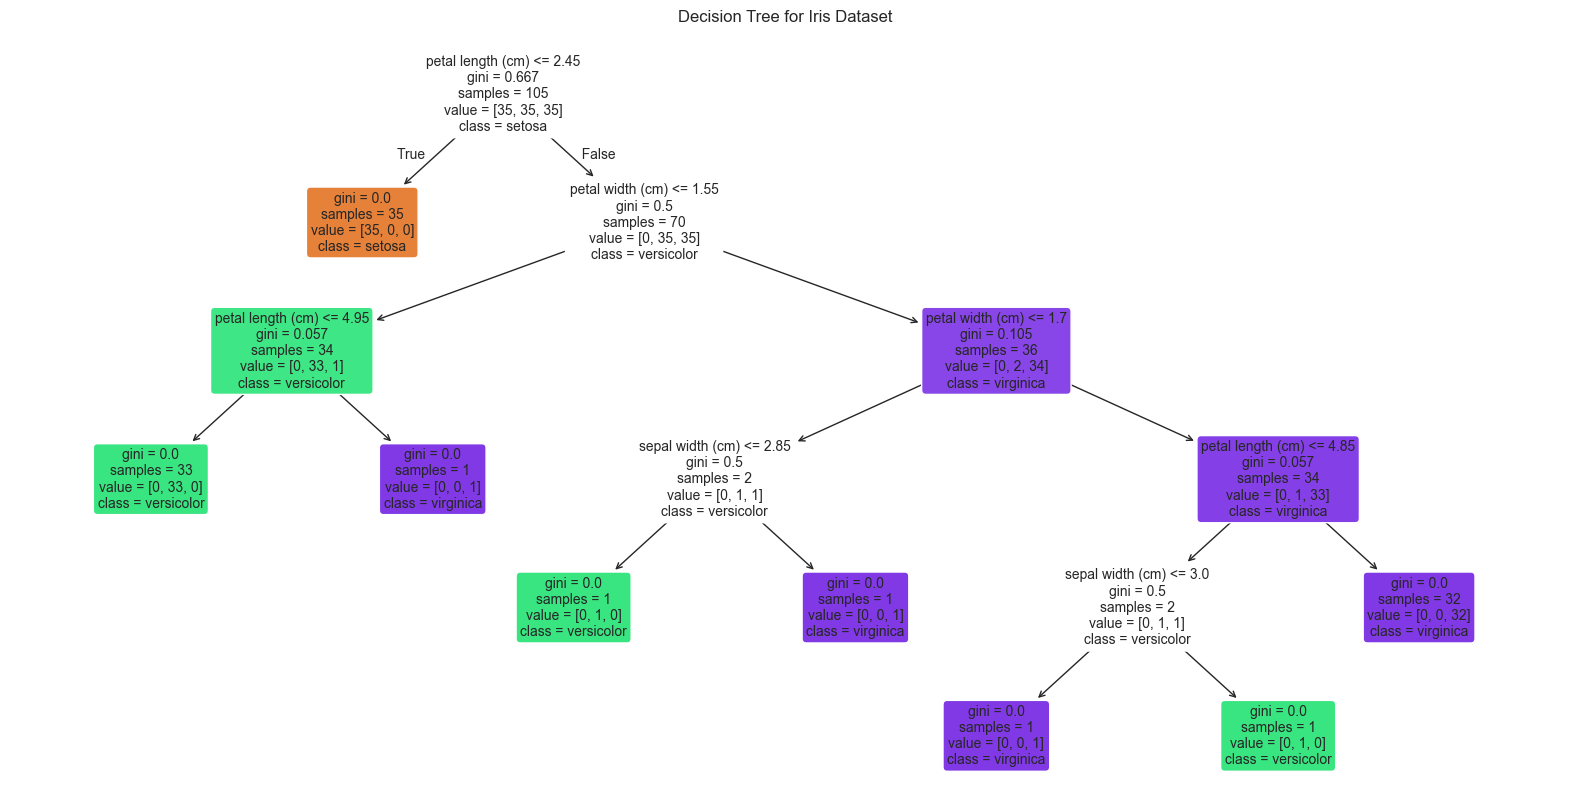

In [11]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier, 
    feature_names=feature_names,
    class_names=target_names,
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Iris Dataset")
plt.show()

In [12]:
# Alternative visualization using graphviz for better readability
try:
    dot_data = export_graphviz(
        dt_classifier,
        out_file=None,
        feature_names=feature_names,
        class_names=target_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph
except Exception as e:
    print(f"Graphviz visualization failed: {e}")
    print("Falling back to matplotlib visualization")
    plt.figure(figsize=(20, 10))
    plot_tree(
        dt_classifier, 
        feature_names=feature_names,
        class_names=target_names,
        filled=True, 
        rounded=True,
        fontsize=10
    )
    plt.title("Decision Tree for Iris Dataset")
    plt.show()

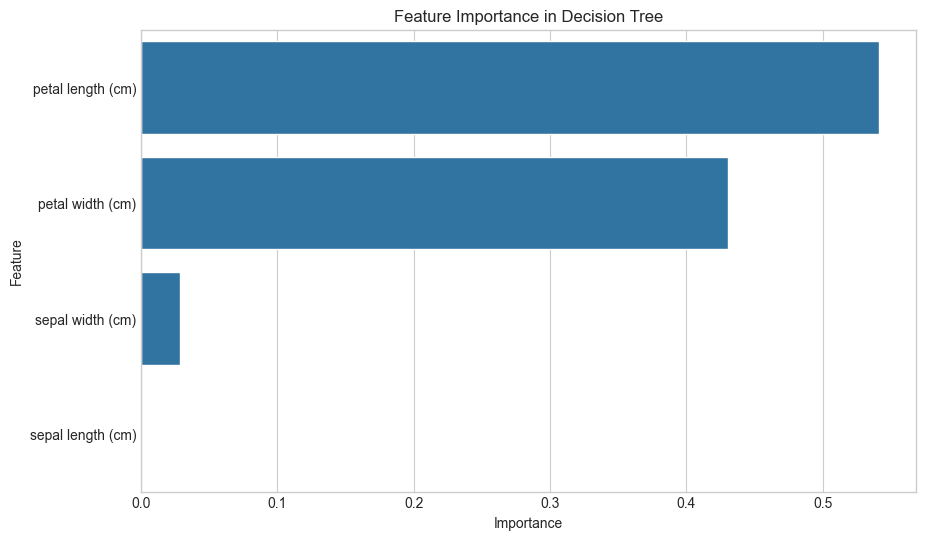

Feature Importance:
petal length (cm): 0.5412
petal width (cm): 0.4303
sepal width (cm): 0.0286
sepal length (cm): 0.0000


In [13]:
# Analysis of feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Feature Importance:")
for index, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

### 3.1 Hyperparameter Tuning for Decision Tree Classifier

Decision trees have several hyperparameters that can be tuned to control the complexity of the tree and prevent overfitting, including:

- `max_depth`: The maximum depth of the tree
- `min_samples_split`: The minimum number of samples required to split an internal node
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node
- `max_features`: The number of features to consider when looking for the best split
- `criterion`: The function to measure the quality of a split (gini or entropy)

Let's use GridSearchCV to find the optimal hyperparameters.

In [14]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a grid search object
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.9524


Accuracy with best parameters: 0.9333
Improvement over default parameters: 0.0000

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



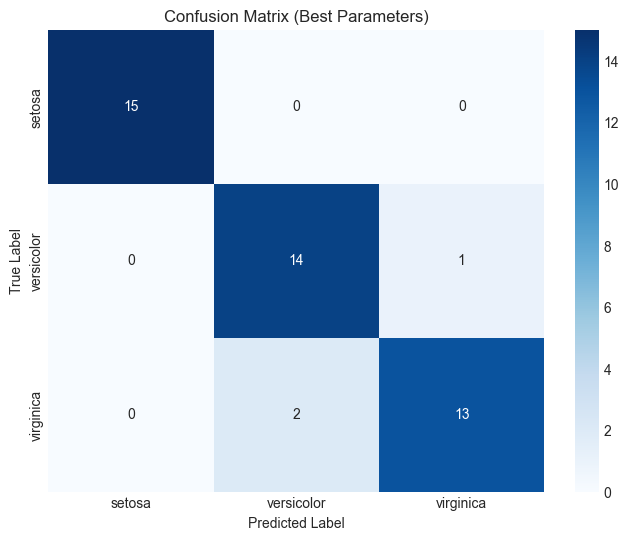

In [15]:
# Train a decision tree with the best parameters
best_dt_classifier = grid_search.best_estimator_

# Make predictions
y_pred_best = best_dt_classifier.predict(X_test)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy with best parameters: {accuracy_best:.4f}")
print(f"Improvement over default parameters: {accuracy_best - accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Best Parameters)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

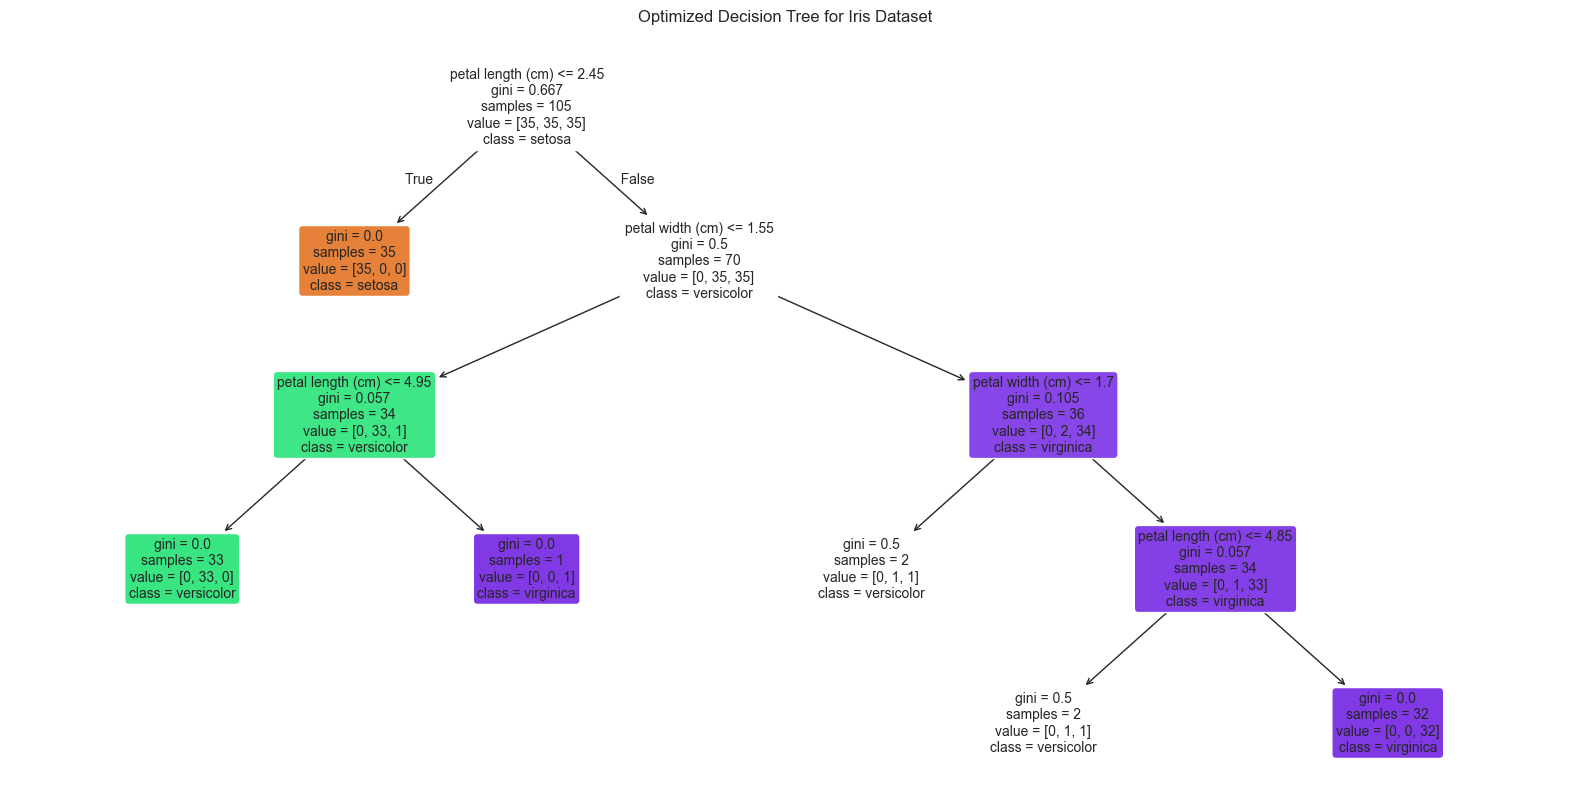

In [16]:
# Visualize the optimized decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_classifier, 
    feature_names=feature_names,
    class_names=target_names,
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.title("Optimized Decision Tree for Iris Dataset")
plt.show()

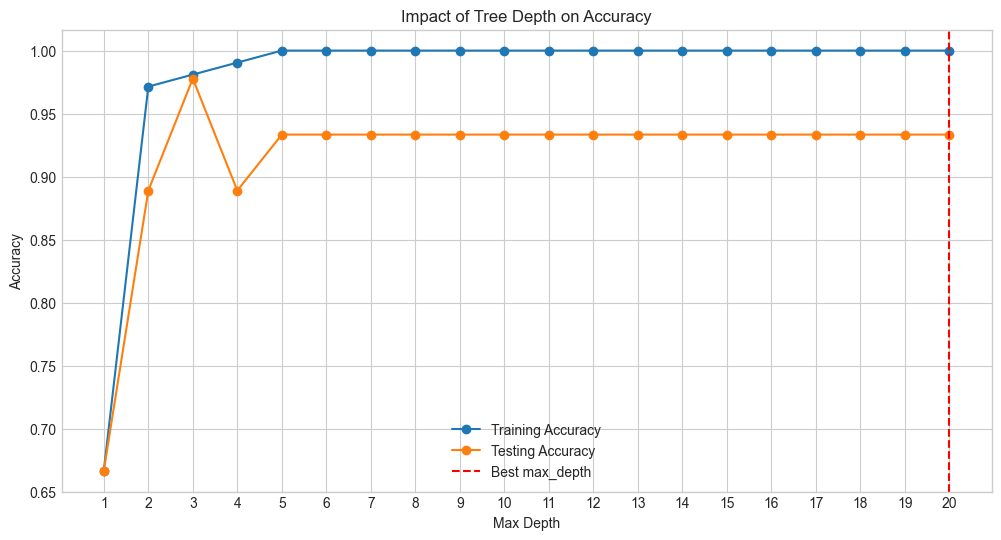

In [17]:
# Analyze the impact of max_depth on accuracy
max_depths = list(range(1, 20)) + [None]
train_accuracy = []
test_accuracy = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy.append(accuracy_score(y_train, dt.predict(X_train)))
    test_accuracy.append(accuracy_score(y_test, dt.predict(X_test)))
    
# Convert None to a value for plotting
max_depths_plot = [20 if d is None else d for d in max_depths]

plt.figure(figsize=(12, 6))
plt.plot(max_depths_plot, train_accuracy, 'o-', label='Training Accuracy')
plt.plot(max_depths_plot, test_accuracy, 'o-', label='Testing Accuracy')
plt.axvline(x=grid_search.best_params_['max_depth'] if grid_search.best_params_['max_depth'] is not None else 20, 
           color='r', linestyle='--', label='Best max_depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Impact of Tree Depth on Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(max_depths_plot)
plt.show()

### 3.2 Multi-class Classification with Decision Trees

Let's apply decision trees to a different multi-class classification dataset - the Wine dataset.

In [18]:
# Load the Wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
wine_feature_names = wine.feature_names
wine_target_names = wine.target_names

# Print basic information
print(f"Dataset shape: {X_wine.shape}")
print(f"Number of classes: {len(np.unique(y_wine))}")
print(f"Class distribution: {np.bincount(y_wine)}")
print(f"Feature names: {wine_feature_names}")
print(f"Target names: {wine_target_names}")

Dataset shape: (178, 13)
Number of classes: 3
Class distribution: [59 71 48]
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']


In [19]:
# Create a DataFrame
wine_df = pd.DataFrame(X_wine, columns=wine_feature_names)
wine_df['target'] = y_wine
wine_df['class'] = [wine_target_names[i] for i in y_wine]

# Display the first few rows
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


Accuracy on Wine dataset: 0.9074

Classification Report:
              precision    recall  f1-score   support

     class_0       0.94      0.89      0.91        18
     class_1       0.86      0.90      0.88        21
     class_2       0.93      0.93      0.93        15

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54



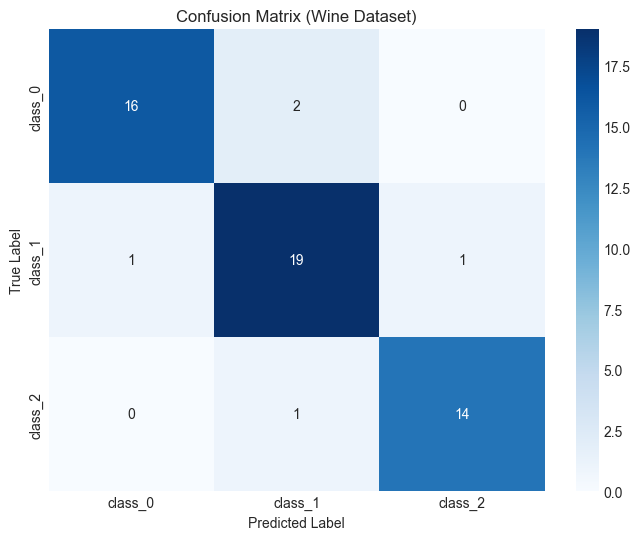

In [20]:
# Split the data
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

# Standardize the features
scaler = StandardScaler()
X_train_wine_scaled = scaler.fit_transform(X_train_wine)
X_test_wine_scaled = scaler.transform(X_test_wine)

# Train a decision tree with grid-search optimized parameters
wine_dt = DecisionTreeClassifier(
    max_depth=5,  # Using a reasonable depth to avoid overfitting
    min_samples_split=2,
    min_samples_leaf=2,
    criterion='entropy',
    random_state=42
)
wine_dt.fit(X_train_wine_scaled, y_train_wine)

# Make predictions
y_pred_wine = wine_dt.predict(X_test_wine_scaled)

# Evaluate the model
wine_accuracy = accuracy_score(y_test_wine, y_pred_wine)
print(f"Accuracy on Wine dataset: {wine_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_wine, y_pred_wine, target_names=wine_target_names))

# Confusion matrix
wine_conf_matrix = confusion_matrix(y_test_wine, y_pred_wine)
plt.figure(figsize=(8, 6))
sns.heatmap(wine_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=wine_target_names, yticklabels=wine_target_names)
plt.title('Confusion Matrix (Wine Dataset)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

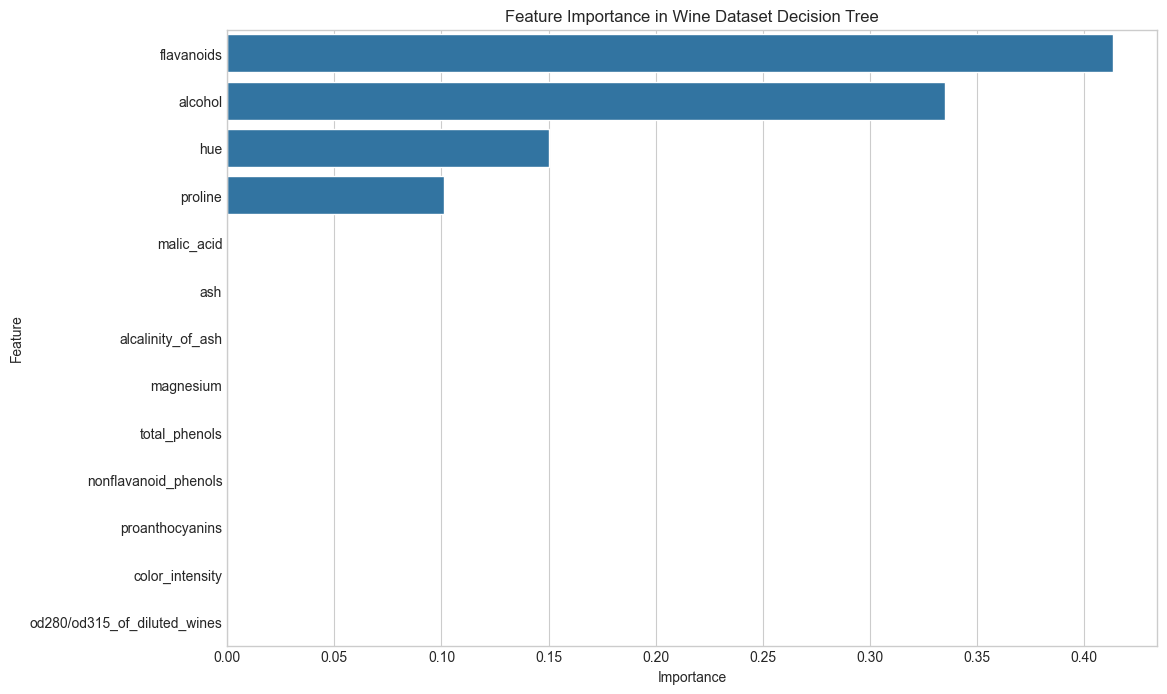

Top 5 Most Important Features:
       Feature  Importance
6   flavanoids    0.413362
0      alcohol    0.335161
10         hue    0.150053
12     proline    0.101424
1   malic_acid    0.000000


In [21]:
# Analyze feature importance for Wine dataset
wine_feature_importance = pd.DataFrame({
    'Feature': wine_feature_names,
    'Importance': wine_dt.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=wine_feature_importance)
plt.title('Feature Importance in Wine Dataset Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Top 5 Most Important Features:")
print(wine_feature_importance.head(5))

## 4. Decision Trees for Regression

In [22]:
# Load a regression dataset (California Housing)
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
housing_feature_names = housing.feature_names

# Print basic information
print(f"Dataset shape: {X_housing.shape}")
print(f"Target range: {y_housing.min():.2f} to {y_housing.max():.2f}")
print(f"Target mean: {y_housing.mean():.2f}")
print(f"Feature names: {housing_feature_names}")

Dataset shape: (20640, 8)
Target range: 0.15 to 5.00
Target mean: 2.07
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [23]:
# Create a DataFrame
housing_df = pd.DataFrame(X_housing, columns=housing_feature_names)
housing_df['target'] = y_housing

# Display the first few rows and summary statistics
print("First few rows:")
print(housing_df.head())

print("\nSummary statistics:")
print(housing_df.describe())

First few rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  

Summary statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154     

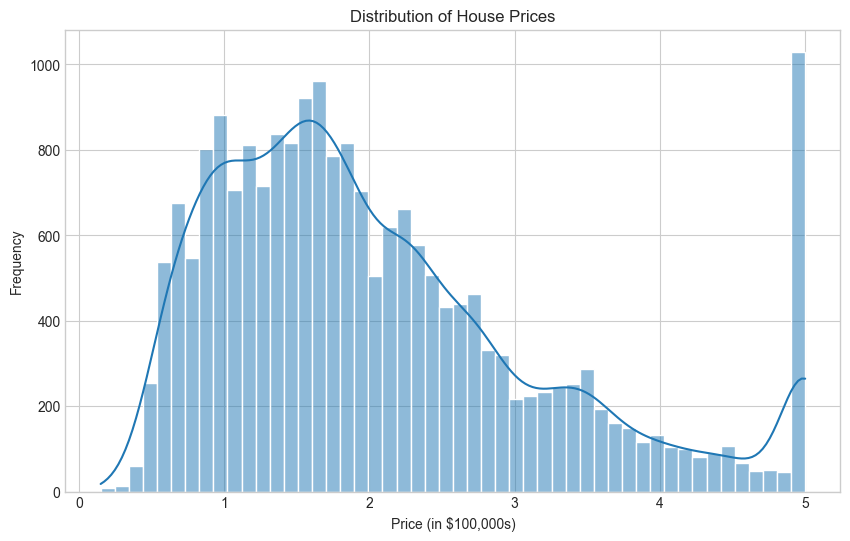

In [24]:
# Visualize the target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_housing, kde=True, bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price (in $100,000s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

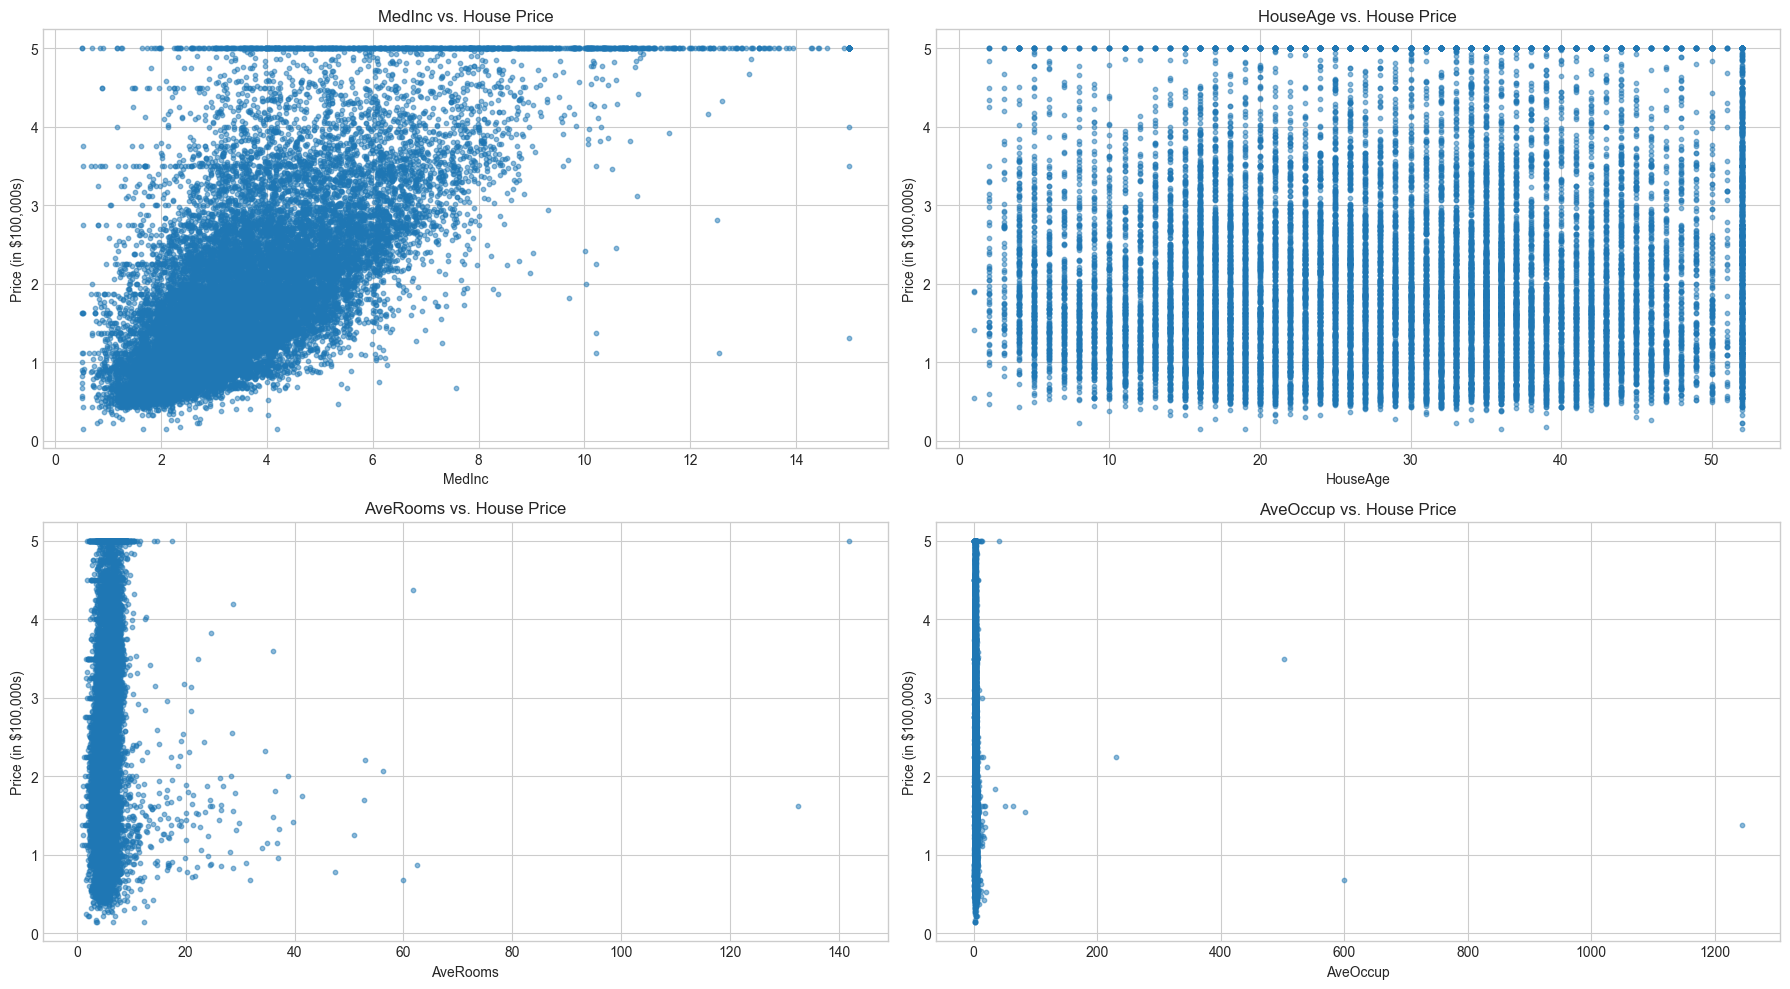

In [25]:
# Explore relationship between some features and the target
plt.figure(figsize=(18, 10))

# Select a subset of features for visualization
features_to_plot = ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    plt.scatter(housing_df[feature], housing_df['target'], alpha=0.5, s=10)
    plt.title(f'{feature} vs. House Price')
    plt.xlabel(feature)
    plt.ylabel('Price (in $100,000s)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Split the data
X_train_housing, X_test_housing, y_train_housing, y_test_housing = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# Standardize the features
scaler_housing = StandardScaler()
X_train_housing_scaled = scaler_housing.fit_transform(X_train_housing)
X_test_housing_scaled = scaler_housing.transform(X_test_housing)

In [27]:
# Train a decision tree regressor with default parameters
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_housing_scaled, y_train_housing)

# Make predictions
y_pred_housing = dt_regressor.predict(X_test_housing_scaled)

# Evaluate the model
mse = mean_squared_error(y_test_housing, y_pred_housing)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_housing, y_pred_housing)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.4940
Root Mean Squared Error: 0.7028
R² Score: 0.6230


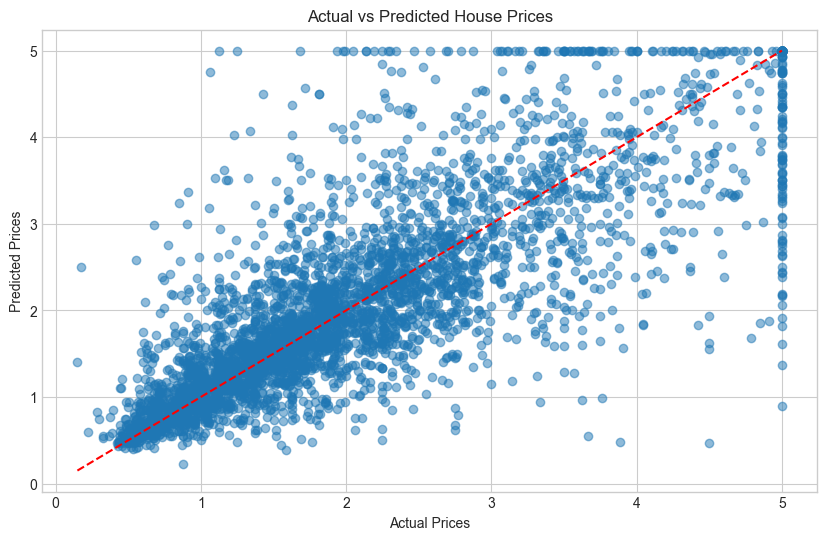

In [28]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_housing, y_pred_housing, alpha=0.5)
plt.plot([y_test_housing.min(), y_test_housing.max()], [y_test_housing.min(), y_test_housing.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.grid(True)
plt.show()

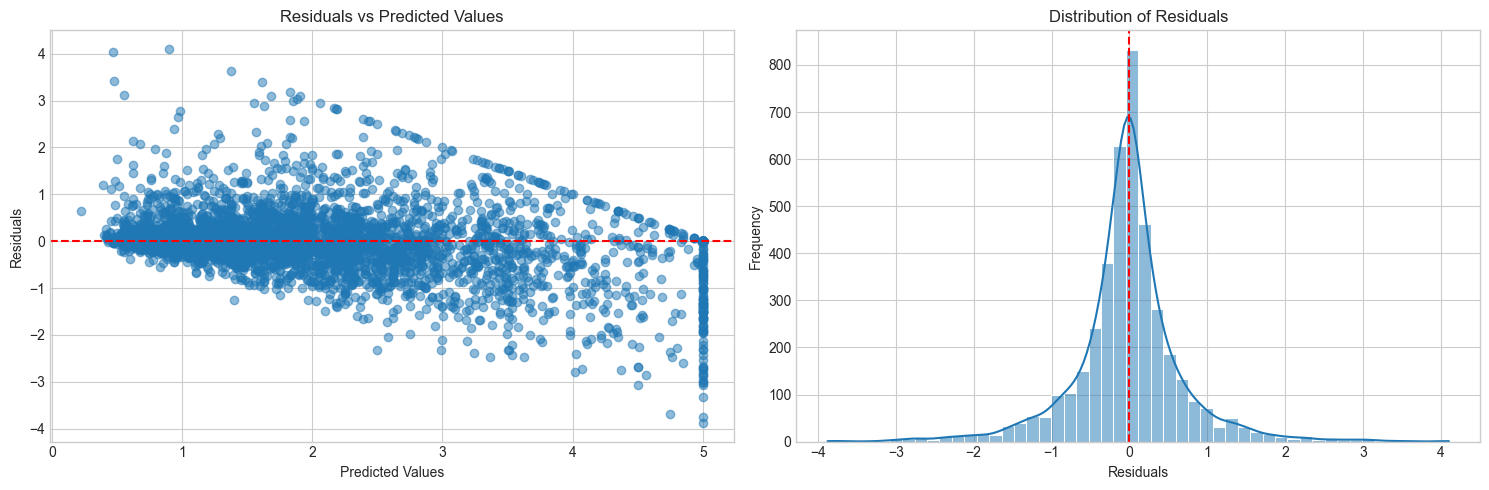

Mean of residuals: -0.0248
Standard deviation of residuals: 0.7024


In [29]:
# Analyze residuals
residuals = y_test_housing - y_pred_housing

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_housing, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Standard deviation of residuals: {residuals.std():.4f}")

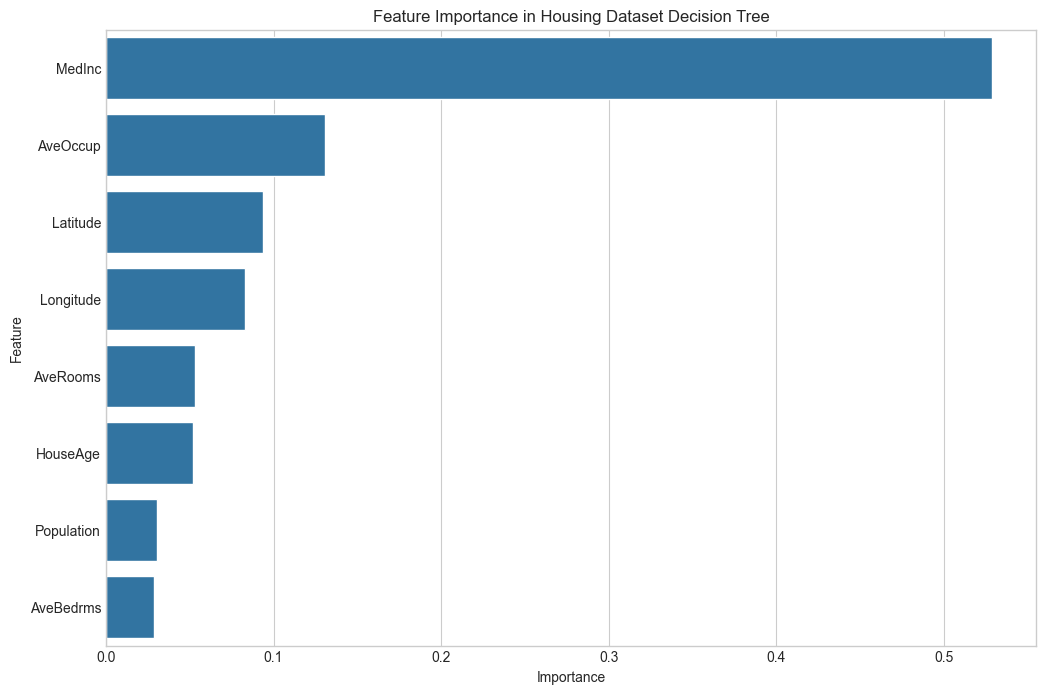

Feature Importance:
MedInc: 0.5285
AveOccup: 0.1308
Latitude: 0.0937
Longitude: 0.0829
AveRooms: 0.0530
HouseAge: 0.0519
Population: 0.0305
AveBedrms: 0.0287


In [30]:
# Feature importance for regression
housing_feature_importance = pd.DataFrame({
    'Feature': housing_feature_names,
    'Importance': dt_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=housing_feature_importance)
plt.title('Feature Importance in Housing Dataset Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()

print("Feature Importance:")
for index, row in housing_feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

## 5. Decision Tree Best Practices and Limitations

### Best Practices:

1. **Control Tree Complexity**: Use hyperparameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` to prevent overfitting.

2. **Visualize the Tree**: For smaller trees, visualization helps in understanding the decision rules.

3. **Feature Engineering**: Decision trees can benefit from well-designed features.

4. **Cross-Validation**: Always use cross-validation to ensure the model generalizes well.

5. **Ensemble Methods**: Consider using ensemble methods (Random Forests, Gradient Boosting) for improved performance.

### Limitations:

1. **Overfitting**: Decision trees can easily overfit the training data, especially with deep trees.

2. **Instability**: Small changes in the data can result in completely different trees.

3. **Bias**: Trees can be biased toward features with more levels.

4. **Linear Relationships**: Not optimal for capturing linear relationships in data.

5. **Boundary Complexity**: Decision boundaries are always perpendicular to the feature axes, which can be a limitation for complex relationships.

## 6. Cross-Validation Analysis

Let's perform a more thorough cross-validation analysis on our decision tree models.

In [32]:
# Cross-validation for classification (Iris dataset)
cv_scores_iris = cross_val_score(
    best_dt_classifier,  # Using our optimized classifier
    X,  # Full dataset
    y,
    cv=10,  # 10-fold cross-validation
    scoring='accuracy'
)

print("Cross-validation scores for Iris Classification:")
print(f"Scores: {cv_scores_iris}")
print(f"Mean Accuracy: {cv_scores_iris.mean():.4f}")
print(f"Standard Deviation: {cv_scores_iris.std():.4f}")

Cross-validation scores for Iris Classification:
Scores: [1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 1.         1.        ]
Mean Accuracy: 0.9600
Standard Deviation: 0.0327


## 7. Learning Curve Analysis

Learning curves help us understand how model performance changes with increasing training data size.

In [34]:
from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

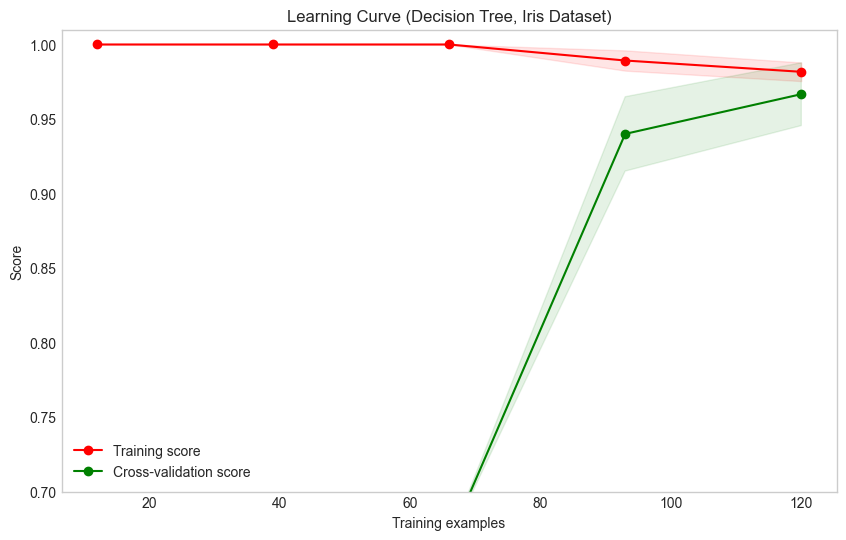

In [35]:
# Learning curve for Iris classification
title = "Learning Curve (Decision Tree, Iris Dataset)"
plot_learning_curve(best_dt_classifier, X, y, title, ylim=(0.7, 1.01), cv=5, n_jobs=-1)
plt.show()

In [36]:
# Function for regression learning curve
def plot_learning_curve_regression(estimator, X, y, title, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Negative MSE")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

## 8. Chapter Summary

In this chapter, we covered decision trees for both classification and regression tasks:

1. **Theory and Mathematical Concepts**:
   - Decision tree structure (root, internal nodes, leaves)
   - Impurity measures (Gini, Entropy, MSE)
   - Splitting criteria and information gain

2. **Classification with Decision Trees**:
   - Implementation on the Iris dataset
   - Visualization and interpretation of the tree
   - Feature importance analysis
   - Hyperparameter tuning and grid search
   - Application to the Wine dataset

3. **Regression with Decision Trees**:
   - Implementation on the California Housing dataset
   - Error analysis and visualization
   - Feature importance for regression
   - Hyperparameter optimization

4. **Model Evaluation and Validation**:
   - Cross-validation
   - Learning curves
   - Overfitting analysis

5. **Best Practices and Limitations**:
   - Guidelines for using decision trees
   - Understanding and addressing their limitations

6. **Model Serialization**:
   - Saving and loading trained models for later use

Decision trees are powerful, intuitive algorithms with a wide range of applications. However, they also have limitations, particularly related to overfitting and instability. In the next chapter, we'll explore Random Forests, an ensemble method that addresses many of these limitations.

## 9. Next Steps

In the next notebook, we'll explore:

1. **Random Forest**: An ensemble method that builds multiple decision trees and combines their predictions.
2. **Bagging and Boosting**: Other ensemble techniques for improving model performance.
3. **Feature Importance Analysis**: How feature importance is calculated in tree ensembles.
4. **Practical Applications**: Real-world scenarios where tree ensembles excel.